# Importing Python Libraries

In [2]:
import os      
import imutils
import cv2
import time
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Extracting Image and Resizing to Standard Dimensions

In [21]:
def get_image(row_id, root=r"C:/Users/cawin/CodeProjects/SUTD/Capstone_S15_HTX/IR/Human-Detection-from-Infrared-Images/Images/"):     # Path like C:/Users/cook/Desktop/IR/
    
    filename = "{}.jpg".format(row_id)                   # Converts an image number into the file path where the image is located
    file_path = os.path.join(root, filename)
    imag = Image.open(file_path)                         # Opens the image, and returns the image as a numpy array
    img=imag.resize((64,128))                            # Resize the original Image
    return np.array(img)


# Extracting HOG Features from Image

In [5]:
def create_features(img):                                                 
    
    color_features = img.flatten()                                                    # flatten three channel color image
    grey_image = rgb2grey(img)                                                        # convert image to greyscale
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(2,2))        # get HOG features from greyscale image
    flat_features = np.hstack(hog_features)                                           # combine color and hog features into a single array
    return flat_features


# Creating HOG Features Matrix for Training Dataset

In [6]:
def create_feature_matrix(label_dataframe): 
    
    c=1
    features_list = []                                   # List of Features of an Image
    for img_id in label_dataframe.index:
        img = get_image(img_id)                          # load image
        image_features = create_features(img)            # get features for image
        features_list.append(image_features)
        print(c)                                         # Displays the count of Images converted to Vector
        c+=1
    feature_matrix = np.array(features_list)             # convert list of arrays into a matrix
    return feature_matrix


# Applying PCA to reduce Dimensionality of Feature Matrix

In [7]:
def pcca(feature_matrix):
                                   
    print('Feature matrix shape is: ', feature_matrix.shape)           # get shape of feature matrix
    ss = StandardScaler()                                              # define standard scaler
    human_stand = ss.fit_transform(feature_matrix)                     # run this on our feature matrix
    pca = PCA(n_components=50)                                         # set the number of components wisely, maybe less than 75
    human_pca = pca.fit_transform(human_stand)                         # use fit_transform to run PCA on our standardized matrix
    print('PCA matrix shape is: ', human_pca.shape)                    # look at new shape
    return human_pca


# Sliding Window Mechanism running throughout an Image

In [8]:
def sliding_window(image, stepSize, windowSize):
    
    for y in range(0, image.shape[0], stepSize):                                  # slide a window across the image
        for x in range(0, image.shape[1], stepSize):                              # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            

# Non-Maximum Suppression for removing False Positive Regions

In [9]:
def non_max_suppression_fast(boxes, overlapThresh):
    
    if len(boxes) == 0:                                                  # if there are no boxes, return an empty list
        return []
    if boxes.dtype.kind == "i":                                          # if the bounding boxes integers, convert them to floats --
        boxes = boxes.astype("float")                                    # this is important since we'll be doing a bunch of divisions
    pick = []                                                            # initialize the list of picked indexes
    x1 = boxes[:,0]                                                      # grab the coordinates of the bounding boxes
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)                                 # compute the area of the bounding boxes 
    idxs = np.argsort(y2)                                                # sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    while len(idxs) > 0:                                                 # keep looping while some indexes still remain in the indexes list
        last = len(idxs) - 1                                             # grab the last index in the indexes list  
        i = idxs[last]                                                   
        pick.append(i)                                                   # add the index value to the list of picked indexes
        xx1 = np.maximum(x1[i], x1[idxs[:last]])                         # find the largest (x, y) coordinates for the start of the bounding box
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])                         # find the smallest (x, y) coordinates for the end of the bounding box
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)                                 # compute the width of the bounding box
        h = np.maximum(0, yy2 - yy1 + 1)                                 # compute the height of the bounding box
        overlap = (w * h) / area[idxs[:last]]                            # compute the ratio of overlap
        idxs = np.delete(idxs, np.concatenate(([last],                   # delete all indexes from the index list that have
            np.where(overlap > overlapThresh)[0])))
    return boxes[pick].astype("int")                                     # return only the bounding boxes that were picked using the integer data type


# Training Procedure for Image Dataset, using Support Vector Classifier 

In [22]:

labels = pd.read_csv(r"C:/Users/cawin/CodeProjects/SUTD/Capstone_S15_HTX/IR/Human-Detection-from-Infrared-Images/Images/ir.csv", index_col=0)     # Path like C:/Users/cook/Desktop/IR/IR.csv
feature_matrix = create_feature_matrix(labels)                                                                        # run create_feature_matrix on our dataframe of images
hp=pcca(feature_matrix)                                                                                               # Reduced Matrix of Image Vectors
X_train = pd.DataFrame(hp)                                 
y_train = pd.Series(labels.label.values)                                       # Access the labels of Training Images
pd.Series(y_train).value_counts()                                              # look at the distrubution of labels in the train set
svm = SVC(kernel='rbf', probability=True, random_state=42)                     # define support vector classifier
svm.fit(X_train, y_train)                                                      # fit model


<ipython-input-5-0430be70df9d>:4: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  grey_image = rgb2grey(img)                                                        # convert image to greyscale


1
2
3
4
Feature matrix shape is:  (4, 150660)


ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=4 with svd_solver='full'

# Applying Trained Model to Detect Human in a Test Image

In [ ]:
imagee = cv2.imread(r"Complete-Path-Of-Test-Image")                                         
scale_percent = 200                                                                         # percent of original size
width = int(imagee.shape[1] * scale_percent / 100)
height = int(imagee.shape[0] * scale_percent / 100)
dim = (width, height)                                                                       # New dimensions of Image Window
image = cv2.resize(imagee, dim, interpolation = cv2.INTER_AREA)                             # resize image
(winW , WinH) = (64 , 128)                                                                  # Dimensions of Sliding Window
t=[]                                                                                        # Feature Matrix for test image portions
k=[]                                                                                        # Indexes corresponding to image portions
for (x, y, window) in sliding_window(image, stepSize=16, windowSize=(winW, winH)):          # loop over the sliding window for each layer of the pyramid
    if window.shape[0] != winH or window.shape[1] != winW:                                  # if the window does not meet our desired window size, ignore it
        continue                                                                                            
    clone = image.copy()
    op=clone[y:y+winH,x:x+winW]
    f=create_features(op)
    t.append(f)
    k.append([x,y])
    cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2.imshow("Window", clone)
    cv2.waitKey(1)
    time.sleep(0.025)
cv2.destroyAllWindows()

# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE WINDOW
# since we do not have a classifier, we'll just draw the window

hpp=pcca(t)
x_p=pd.DataFrame(hpp)
y_p=svm.predict(x_p)
pp=list(y_p)                                                                                # Predict the portions where human is detected
clon = image.copy()
nn=[]                                                                                       # List of indexes of Human Detection Portions
for i in range(0,len(pp)):
    if pp[i]==1.0:
        x=k[i][0]
        y=k[i][1]
        nn.append([x,y,x+winW,y+winH])
        cv2.rectangle(clon, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window", clon)
        cv2.waitKey(50)
        time.sleep(0.025)
cv2.destroyAllWindows()

ll=non_max_suppression_fast(np.array(nn),0.4)                                              # Applied Non-Max Suppression on Human Detected portions
l=list(ll)                                                                                 # List of Indexes of Actual Human Regions 
clo=image.copy()
for kl in l:
    cv2.rectangle(clo, (kl[0], kl[1]), (kl[2],kl[3]), (0, 255, 0), 1)                      # Display the most probable Detection Regions out of False Positives
    cv2.imshow("Window", clo)
    cv2.waitKey(0)
    time.sleep(0.025)
cv2.destroyAllWindows()


In [5]:
import cv2
from pytorchyolo import detect, models

# Load the YOLO model
model = models.load_model(
  r"C:/Users/cawin/CodeProjects/SUTD/Capstone_S15_HTX/IR/Human-Detection-from-Infrared-Images/cfg/yolov3.cfg", 
  r"C:/Users/cawin/CodeProjects/SUTD/Capstone_S15_HTX/IR/Human-Detection-from-Infrared-Images/weights/yolov3.weights")

# Load the image as a numpy array
img = cv2.imread("C:/Users/cawin/CodeProjects/SUTD/Capstone_S15_HTX/IR/Human-Detection-from-Infrared-Images/Images/1.jpg")

# Convert OpenCV bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Runs the YOLO model on the image 
boxes = detect.detect_image(model, img)

print(boxes)
# Output will be a numpy array in the following format:
# [[x1, y1, x2, y2, confidence, class]]

ModuleNotFoundError: No module named 'cv2'


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

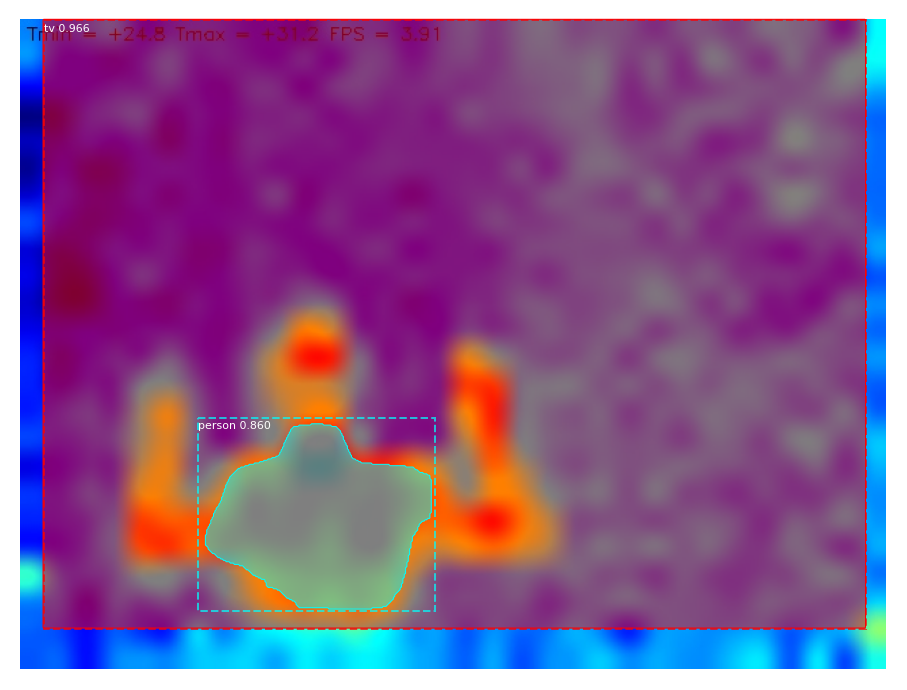

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
prediction time taken: 8.640621423721313
[[  0   9 452 506]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
[0.9667855]
[63]


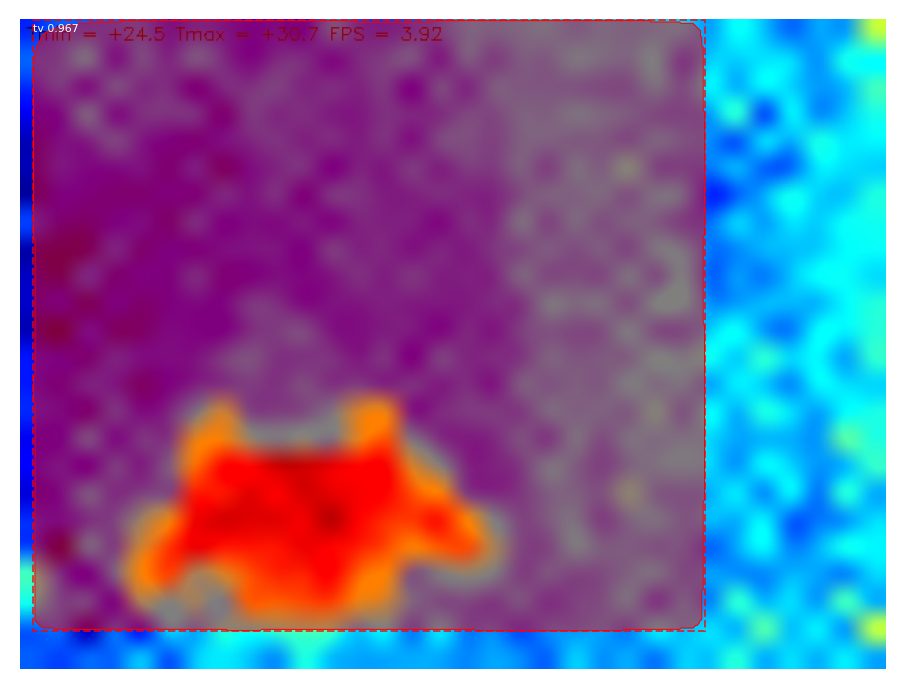

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: 

In [9]:
import os
import sys
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import time

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model|
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "Images")

class InferenceConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # Give the configuration a recognizable name
    NAME = "coco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80 

config = InferenceConfig()
config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake|', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Load a random image from the images folder
for file_name in os.listdir("Images"):
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
    start = time.time()
    # Run detection
    results = model.detect([image], verbose=1)
    stop = time.time()
    print("prediction time taken:",stop-start)
    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])